# Mixture of Experts (MoE) Transformer Analysis and Inference Notebook
 
This notebook provides a comprehensive suite of tools for analyzing and performing inference with Mixture 
of Experts (MoE) Transformer models trained in [moe-transformer.ipynb](./moe-transformer.ipynb). It is 
part of the [moe-experiments](https://github.com/tsh-03/moe-experiments) repository and is designed for 
research, diagnostics, and interpretability of MoE models.

## Overview
- **Author:** Tirth Shah
- **Inspired by:** [FareedKhan-dev/train-llama4](https://github.com/FareedKhan-dev/train-llama4)
- **Repository:** https://github.com/tsh-03/moe-experiments

## Features
- Load and evaluate trained MoE Transformer models from checkpoints.
- Analyze routing entropy and expert utilization across all layers and training steps.
- Visualize training and test metrics, including loss curves and top-k accuracy.
- Generate text samples using the trained model.

## Usage
1. **Setup:** Ensure all dependencies and modules from this repository are available in your environment.
2. **Model Loading:** Specify the path to a trained model checkpoint in the `saved_models` directory.
3. **Analysis:** Run the notebook cells to compute and visualize routing statistics, expert utilization, 
and model performance.
4. **Text Generation:** Use the provided utilities to generate text samples from the trained model.

## Structure
- **Model Loading:** Load trained model and associated training statistics.
- **Analysis:** Compute and plot routing entropy and expert utilization.
- **Evaluation:** Calculate and visualize training/test loss and top-k accuracy.
- **Text Generation:** Generate sequences using the trained model.

## License
This project is licensed under the MIT License. See the [LICENSE](./LICENSE) file for details.

## Citation
If you use this codebase or notebook in your work, please cite the repository and acknowledge the original 
inspiration.

---

## Import Required Libraries and Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import our custom modules
from model import MoETransformer, ModelConfig
from prepare_data import CharDataset, TinyStoriesDataset, sample_alice_text
from train import TrainModel
import utils

c:\Users\hetus\miniconda3\envs\moe-experiments\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Select device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load model

In [3]:
# Load the trained MoETransformer model
model_path = './saved_models/tiny_stories_random_routing_False_top_2.pth'

model, train_config, train_losses, routing_entropies, expert_utilizations = utils.load_model(model_path)
model.to(device)
model.eval()

# normalize expert_utilizations to probabilities
expert_utilizations = expert_utilizations / expert_utilizations.sum(axis=-1, keepdims=True)

Model loaded from ./saved_models/tiny_stories_random_routing_False_top_2.pth


Moving average of train losses, routing entropies, and expert utilizations

In [4]:
window_size = 30

routing_entropies_ma = np.apply_along_axis(utils.moving_average, 0, routing_entropies, window_size)
expert_utilizations_ma = np.apply_along_axis(
    lambda x: utils.moving_average(x, window_size), 0, expert_utilizations
)
train_losses_ma = utils.moving_average(train_losses, window_size)

Get the dataset (and tokenizer) on which the model was trained

In [5]:
if model.config.dataset_tag == 'sample_alice':
    block_size = 64 # Define the block size for the dataset
    dataset = CharDataset(text=sample_alice_text, block_size=block_size) # Create dataset

elif model.config.dataset_tag == 'tiny_stories':
    block_size = 64 # Define the block size for the dataset
    dataset = TinyStoriesDataset(block_size=block_size, max_samples=100000)  # Load the dataset

else:
    raise ValueError("Invalid dataset_tag. Choose 'sample_alice' or 'tiny_stories'.")

TinyStoriesDataset loaded with 100000 stories and vocabulary size 17938


Initialize the TrainModel class (useful for test-loss and top-5 accuracy calculation)

In [6]:

train_model = TrainModel(
    train_config=train_config,
    model=model,
    dataset=dataset,
)

## Analyze

### Generate sequence

In [7]:
if model.config.dataset_tag == 'sample_alice':
    seed_text = "Alice"
elif model.config.dataset_tag == 'tiny_stories':
    seed_text = "Once upon a time"

model.generate(
    seed_text=seed_text,
    tokenizer=dataset.tokenizer,
    max_new_tokens=model.config.block_size,
)

Generation loop finished.


'Once upon a time, there was a little girl named Lily. She loved to play and eat carrots. One day, she found some her friend named Sue. Sue was very weak and always discussed to her aunt with her favorite basketball.\n\nLily ran to his friend, Tommy, came over to sandwiches. Sue was good at Max'

### Training loss

Final smoothed training loss: 2.4548478762308754


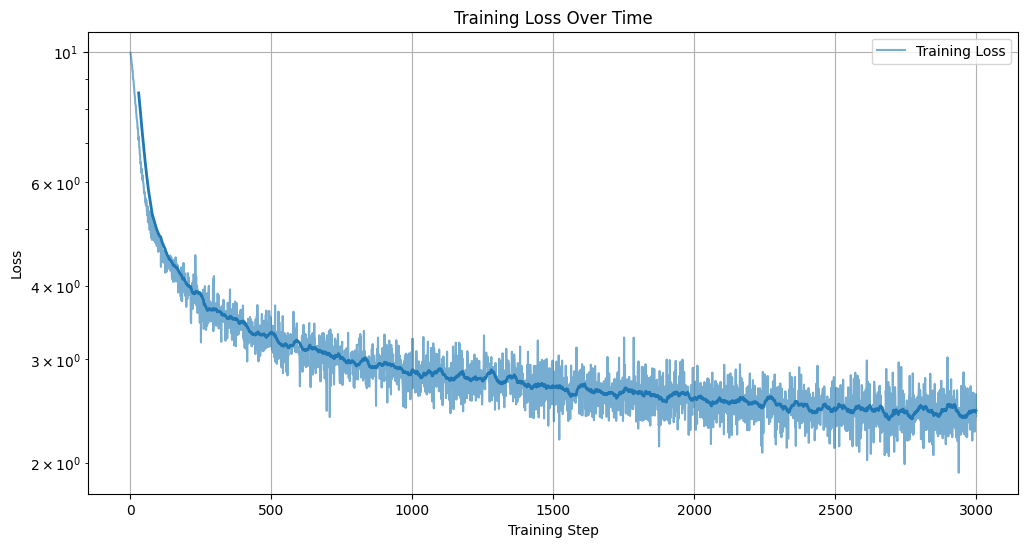

In [ ]:
print(f"Final smoothed training loss: {train_losses_ma[-1]}")

plt.figure(figsize=(12, 6))
actual_line = plt.plot(train_losses, label='Training Loss', alpha=0.6)[0]
color = actual_line.get_color()
plt.plot(np.arange(window_size - 1, len(train_losses)), train_losses_ma, color=color, linewidth=2)
plt.title('Training Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
# plt.savefig('./images/loss_vs_step.png')
plt.show()

### Test loss

In [12]:
test_loss = train_model.test_loss()

print(f"Test loss: {test_loss:.2f}")

Test loss: 2.44


### Top-k Accuracy

In [13]:
k = 3  # Top-k accuracy
top_k_accuracy = train_model.test_top_k_accuracy(k)

print(f"Top-{k} accuracy: {top_k_accuracy:.2f}")

Top-3 accuracy: 67.07


### Routing Entropies

Routing Entropies (Final value for all layers: [1.06 1.02 0.95 0.78 0.65])


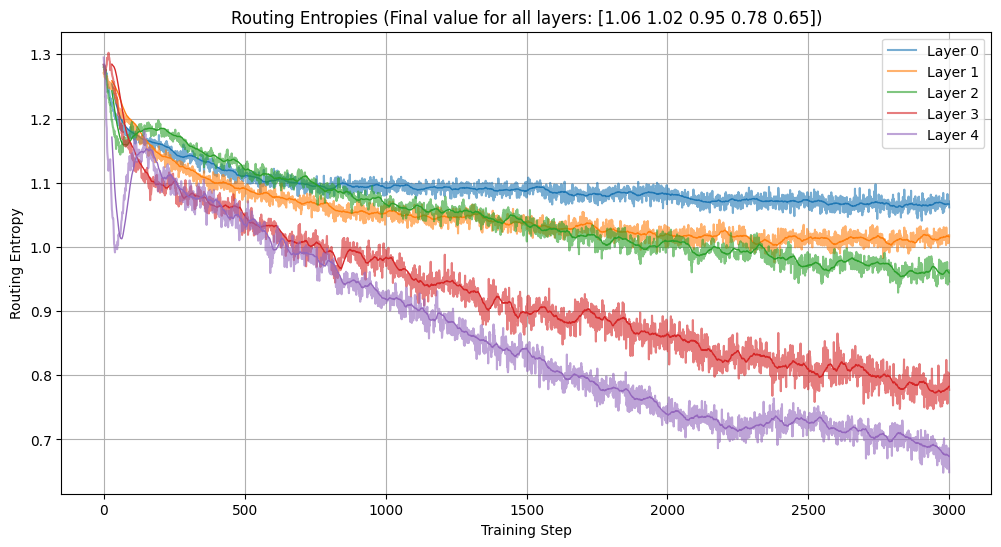

In [ ]:
# Print final routing entropies
print(f'Routing Entropies (Final value for all layers: {np.round(routing_entropies[-1], 2)})')

# Plot routing entropies
plt.figure(figsize=(12, 6))
for layer_idx in range(routing_entropies.shape[1]):
    # Plot actual line and get its color
    actual_line, = plt.plot(routing_entropies[:, layer_idx], label=f'Layer {layer_idx}', alpha=0.6)
    color = actual_line.get_color()
    # Plot smoothed line with the same color
    plt.plot(
        np.arange(window_size - 1, len(routing_entropies)),
        routing_entropies_ma[:, layer_idx],
        linewidth=1,
        color=color
    )
plt.title(f'Routing Entropies (Final value for all layers: {np.round(routing_entropies[-1], 2)})')
plt.xlabel('Training Step')
plt.ylabel('Routing Entropy')
plt.legend()
plt.grid()
# plt.savefig('./images/routing_entropy_vs_step.png')
plt.show()


### Expert Utilizations

Standard deviation of expert utilizations at the end of training: [0.03 0.02 0.07 0.05 0.11]


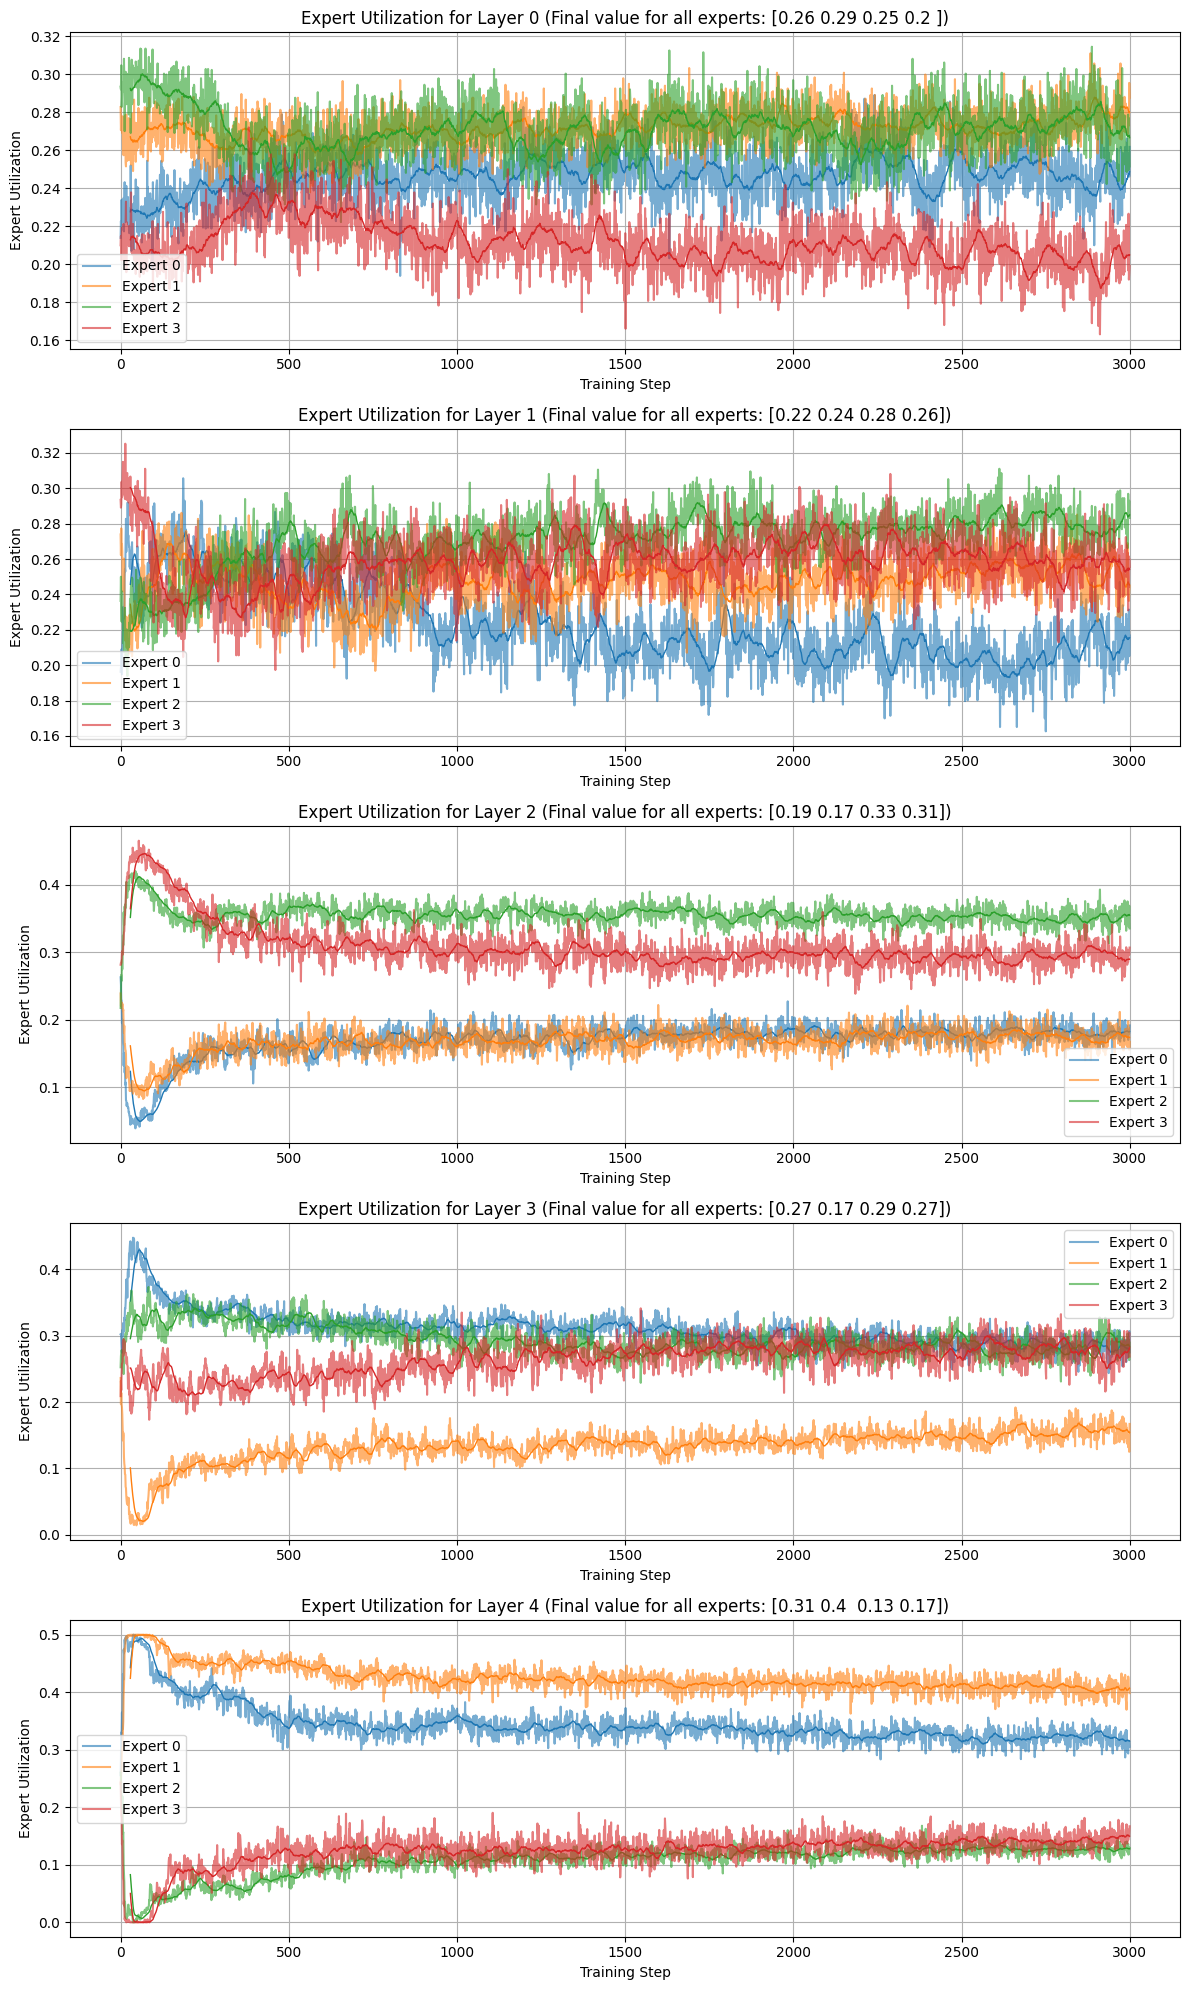

In [ ]:
# Print standard deviation of expert utilizations at the end of training
utilization_std = np.std(expert_utilizations[-1], axis=-1)
print(f"Standard deviation of expert utilizations at the end of training: {np.round(utilization_std, 2)}")

# Plotting
fig, axes = plt.subplots(expert_utilizations.shape[1], 1, figsize=(12, 4 * expert_utilizations.shape[1]))

for layer_idx in range(expert_utilizations.shape[1]):
    ax = axes[layer_idx] if expert_utilizations.shape[1] > 1 else axes
    lines = []
    for expert_idx in range(expert_utilizations.shape[2]):
        # Plot actual line and get its color
        line, = ax.plot(expert_utilizations[:, layer_idx, expert_idx], label=f'Expert {expert_idx}', alpha=0.6)
        color = line.get_color()
        # Plot smoothed line with the same color
        ax.plot(
            np.arange(window_size - 1, len(expert_utilizations)),
            expert_utilizations_ma[:, layer_idx, expert_idx],
            linewidth=1,
            color=color
        )
        lines.append(line)
    ax.set_title(f'Expert Utilization for Layer {layer_idx} (Final value for all experts: {np.round(expert_utilizations[-1, layer_idx, :], 2)})')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Expert Utilization')
    ax.legend()
    ax.grid()

plt.tight_layout()
# plt.savefig('./images/expert_utilization_vs_step.png')
plt.show()